### Use the National Land Cover Database to make roughness maps of Manning's n

The friction factor used in hydrodynamics models to calculate bottom stress ${\tau}_b = C_fU|U|$ is related to Manning's n as $C_f = gn^2/h^{1/3}$. Including the higher values of $C_f$ usually found on land may improve innundation calculations.

The USGS has a bulk license for Global Mapper, and it is super-easy to load the NLCD into Global Mapper. So here is a Python workflow that gets the Manning's n values into Matlab.

The steps are:
1. Get the NLCD values for your study site using Global Mapper and save them as a geotiff file
2. Load the geotiff into a Python array
3. Make same-sized arrays of lat/lon
4. Use the NLCD indices as a look-up table (dict) to make an array of Manning's n
5. Smooth the roughness map
6. Save the  arrays (lat, lon, nmap, and nmaps) in Matlab format

### Key references

Home for the National Land Cover Database: https://www.mrlc.gov/index.php

Preferred NLCD 2011 citation: Homer, C.G., Dewitz, J.A., Yang, L., Jin, S., Danielson, P., Xian, G., Coulston, J., Herold, N.D., Wickham, J.D., and Megown, K., 2015, Completion of the 2011 National Land Cover Database for the conterminous United States-Representing a decade of land cover change information. Photogrammetric Engineering and Remote Sensing, v. 81, no. 5, p. 345-354 .

Conversion from land classification to roughness:

Mattocks, C., Forbes, C., 2008. A real-time, event-triggered storm surge forecasting system for the state of North Carolina. Ocean Modelling 25, 95–119. https://doi.org/10.1016/j.ocemod.2008.06.008.

Mattocks, C., Forbes, C., Ran, L., 2006. Design and implementation of a real-time storm surge and ﬂood forecasting capability for the State of North Carolina. UNC–CEP Technical Report, November 30, 2006, 103 pp.

## 1.  It is super easy to pull the NLCD for a region using GlobalMapper.

![Import NLCD into Global Mapper](./GM_NLCD_import.png)


### I saved it as an 8-bit palette geotiff image with no resampling.

![Export NLCD from Global Mapper as a geotiff](./GM_NLCD_export_geotiff.png)

### You could also maybe pull it in directly using the Ecohydrolib package:    
http://pythonhosted.org/ecohydrolib/namespaceecohydrolib_1_1nlcd_1_1daacquery.html

## Import the necessary packages

All of these are in the IOOS3 conda environment, which you can create following Rich Signell's instructions here:
http://ioos.github.io/notebooks_demos/other_resources/

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.io
import scipy.ndimage
from pyproj import Proj, transform
%matplotlib inline

## 2. Load the geotiff containing the classification array into Python

In [2]:
# read in the nlcd classifications as an array called z
with rasterio.open("nlcd2011_fireisland_8bitpalette.tif") as lc:
    z = lc.read(1)
    print("shape of the array is",np.shape(z))

print("Here is a snippet of the array:")
z

shape of the array is (523, 945)
Here is a snippet of the array:


array([[23, 22, 22, ..., 22, 22, 22],
       [23, 22, 22, ..., 23, 23, 23],
       [23, 23, 22, ..., 24, 24, 23],
       ..., 
       [11, 11, 11, ...,  0,  0,  0],
       [11, 11, 11, ...,  0,  0,  0],
       [11, 11, 11, ...,  0,  0,  0]], dtype=uint8)

## 3. Determine the coordinate system, convert to lat/lon, and make arrays of lat and lon

In [3]:
# investigate coordinate reference system
print("Info on the coordinate reference system:")
print(lc.crs)
# data transform
print(lc.transform)

# convert from array index to coordinate units
# upper left, upper right corner
ul = lc.transform*(0,0)
ur = lc.transform*(lc.width,0)
# lower right , lower left corners
ll = lc.transform*(0,lc.height)
lr = lc.transform*(lc.width, lc.height)

# convert corners to lat/lon
inProj = Proj(init='epsg:3395')  # World mercator
outProj = Proj(init='epsg:4326') # WGS84 lat/lon

ul_lon,ul_lat=transform(inProj,outProj,ul[0],ul[1])
lr_lon,lr_lat=transform(inProj,outProj,lr[0],lr[1])
print("upper left lon/lat:  ",ul_lon,ul_lat)
print("lower right lon/lat: ",lr_lon,lr_lat)


Info on the coordinate reference system:
CRS({'init': 'epsg:3395'})
| 38.22, 0.00,-8146622.73|
| 0.00,-38.22, 4953295.80|
| 0.00, 0.00, 1.00|
upper left lon/lat:   -73.18235714326453 40.788637393225294
lower right lon/lat:  -72.85791714082312 40.65202326338797


In [4]:
# make same-sized arrays of lat and lon
lons = np.linspace(ul_lon,lr_lon,lc.width);
lats = np.linspace(ul_lat,lr_lat,lc.height);
lon, lat = np.meshgrid(lons, lats)

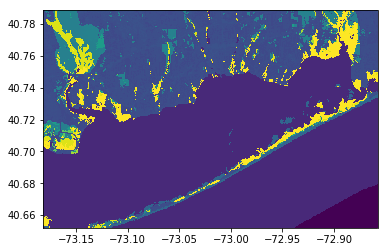

In [5]:
# very quick and dirty look at a map of the indices
plt.pcolormesh(lon,lat,z)

## 4. Make a dict to convert from NLCD number to Manning's n and surface roughness length

### Here is the table from Mattocks and Forbes (2008) showing the classification values

![From Mattocks and Forbes (2008)](./nlcd_to_roughness.png)
    

### Make the look-up table (dict)...use 0.02 (same as open water) for missing values (class 0)

In [6]:
n = {11:0.02, 12:0.10, 21:0.02, 22:0.05, 23:0.10, 24:0.15,\
     31:0.09, 32:0.04, 41:0.10, 42:0.11, 43:0.10, 51:0.04,\
     52:0.05, 71:0.034, 72:0.03, 73:0.027, 74:0.025, 81:0.033,\
     82:0.037, 90:0.10, 91:0.10, 92:0.048, 93:0.10, 94:0.048,\
     95:0.045, 96:0.045, 97:0.045, 98:0.015, 99:0.015,\
     0:0.02} 

print("Manning's n value for class 11: n[11]=",n[11])
print("Class number at index 150,150: z[150,150]=", z[150,150])
print("Manning's n value for the class number at index 150,150: n[z[150,150]]=",n[z[150,150]])

#TODO - make similar dicts for roughness and canopy

Manning's n value for class 11: n[11]= 0.02
Class number at index 150,150: z[150,150]= 41
Manning's n value for the class number at index 150,150: n[z[150,150]]= 0.1


### Look up the Manning's n value for each value in the classification array

In [7]:
# initialize a float array with same shape as class array
nmap = 0.0*np.ones_like(z)
(ni,nj)=np.shape(z)
print(np.shape(z),np.shape(nmap))
print(ni,nj)
# loop through and assign Manning's n value to array using class look-up table
for i in range(ni):
    for j in range(nj):
        nmap[i,j]=n[z[i,j]]

(523, 945) (523, 945)
523 945


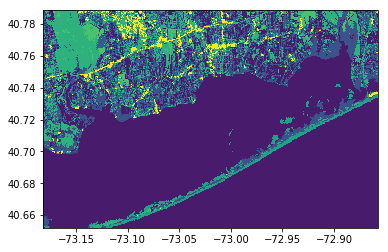

In [8]:
# another quick and dirty map
plt.pcolormesh(lon,lat,nmap,vmin=0.01,vmax=.15)

## 5) Smooth the data before mapping it to the model grid
### Smooth with a 3 x 3 Gaussian filter

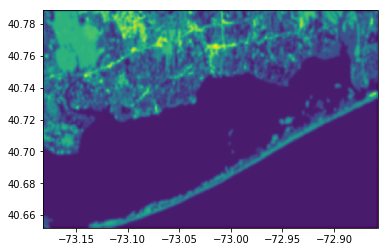

In [9]:
# Apply gaussian filter over 3 x 3 cells
sigma = [3, 3]
nmaps = scipy.ndimage.filters.gaussian_filter(nmap, sigma, mode='constant')

# Display filtered array
plt.pcolormesh(lon,lat,nmaps,vmin=0.01,vmax=0.15)

## 6) Save the arrays in Matlab .mat format (or continue to process in Python...)

In [10]:
scipy.io.savemat('./allmaps.mat', mdict={'lat':lat,'lon':lon,'nmap': nmap,'nmaps':nmaps})

### Matlab commands to load and plot:
<pre>
>> load allmaps
>> pcolor(lon,lat,nmap)
>> shading interp
</pre>

#### and the results:

!['NLCD Mannings n plotted in Matlab'](./nlcd_matlab_plot.png)


### TODO - improve the look by using the colormap used by USGS and ESRI
#### from: nlcd_2011_landcover_2011_edition_2014_10_10.xml
<pre>
Attributes defined by USGS and ESRI.
Value Red            Green           Blue
0     0.00000000000  0.00000000000  0.00000000000
11    0.27843137255  0.41960784314  0.62745098039
12    0.81960784314  0.86666666667  0.97647058824
21    0.86666666667  0.78823529412  0.78823529412
22    0.84705882353  0.57647058824  0.50980392157
23    0.92941176471  0.00000000000  0.00000000000
24    0.66666666667  0.00000000000  0.00000000000
31    0.69803921569  0.67843137255  0.63921568628
41    0.40784313726  0.66666666667  0.38823529412
42    0.10980392157  0.38823529412  0.18823529412
43    0.70980392157  0.78823529412  0.55686274510
51    0.64705882353  0.54901960784  0.18823529412
52    0.80000000000  0.72941176471  0.48627450980
71    0.88627450980  0.88627450980  0.75686274510
72    0.78823529412  0.78823529412  0.46666666667
73    0.60000000000  0.75686274510  0.27843137255
74    0.46666666667  0.67843137255  0.57647058824
81    0.85882352941  0.84705882353  0.23921568628
82    0.66666666667  0.43921568628  0.15686274510
90    0.72941176471  0.84705882353  0.91764705882
95    0.43921568628  0.63921568628  0.72941176471
</pre>